In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "drive/MyDrive/spectrograms_final.zip"

In [15]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
!pip install pydub
from pydub import AudioSegment

In [16]:
sounds = ['Laughter', 'car_horn', 'dog_barking', 'drilling', 'Fart', 'Guitar', 'Gunshot_and_gunfire', 'Hi-hat', 'Knock',
          'Shatter', 'siren', 'Snare_drum', 'Splash_and_splatter']

In [17]:
batch_size = 16
img_height = 224
img_width = 224

In [18]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
  "content/spectrograms/train/",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4860 files belonging to 13 classes.


In [19]:
val_ds = train_ds = tf.keras.utils.image_dataset_from_directory(
  "content/spectrograms/val/",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1209 files belonging to 13 classes.


In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, BatchNormalization, Dropout, Input
import keras.regularizers as regularizers
import keras.initializers as initializers

In [36]:
def conv_block(input_tensor, num_channels, strides=(1, 1)):
    x = layers.Conv2D(num_channels, (1, 1), strides=strides)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_channels, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_channels * 4, (1, 1))(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(num_channels * 4, (1, 1), strides=strides)(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def identity_block(input_tensor, num_channels):
    x = layers.Conv2D(num_channels, (1, 1))(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_channels, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_channels * 4, (1, 1))(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def resnet50(input_shape=(224, 224, 3), classes=13):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = layers.ZeroPadding2D((3, 3))(x)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D((1, 1))(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 64, strides=(1, 1))
    x = identity_block(x, 64)
    x = identity_block(x, 64)

    x = conv_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)

    x = conv_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)

    x = conv_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(classes)(x)

    model = tf.keras.Model(inputs, x)
    return model

In [ ]:
model = resnet50()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

In [25]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
76/76 [==============================] - 295s 3s/step - loss: 2.7256 - accuracy: 0.2142 - val_loss: 2.4411 - val_accuracy: 0.1712
Epoch 2/20
76/76 [==============================] - 184s 2s/step - loss: 2.1022 - accuracy: 0.3342 - val_loss: 2.2914 - val_accuracy: 0.2473
Epoch 3/20
76/76 [==============================] - 183s 2s/step - loss: 1.8884 - accuracy: 0.3945 - val_loss: 2.2634 - val_accuracy: 0.2845
Epoch 4/20
76/76 [==============================] - 184s 2s/step - loss: 1.7040 - accuracy: 0.4648 - val_loss: 3.5635 - val_accuracy: 0.2167
Epoch 5/20
76/76 [==============================] - 184s 2s/step - loss: 1.5655 - accuracy: 0.4806 - val_loss: 1.7806 - val_accuracy: 0.4086
Epoch 6/20
76/76 [==============================] - 184s 2s/step - loss: 1.4185 - accuracy: 0.5219 - val_loss: 1.7230 - val_accuracy: 0.4433
Epoch 7/20
76/76 [==============================] - 183s 2s/step - loss: 1.3463 - accuracy: 0.5517 - val_loss: 2.4099 - val_accuracy: 0.3788
Epoch 8/20
76

In [29]:
prediction = model.predict(val_ds)

76/76 [==============================] - 45s 585ms/step


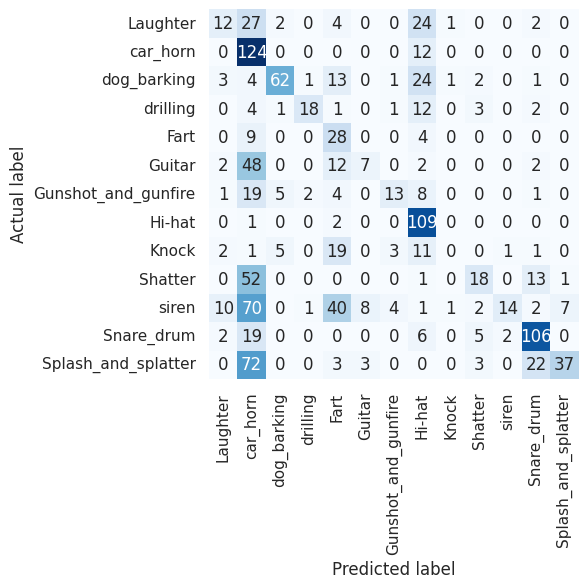

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

val_images, val_labels = zip(*val_ds.unbatch().as_numpy_iterator())
val_labels = np.array(val_labels)

predicted_labels = prediction.argmax(axis=1)

mat = confusion_matrix(val_labels, predicted_labels)
# class_labels = ['background', 'chainsaw', 'engine', 'storm']  # replace with your actual class labels

sns.set_theme()
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=sounds,
            yticklabels=sounds)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()
